In [3]:
#!/usr/bin/env python3
# title           :mcdwt_evaluate.py
# description     :script for evaluation of mcdwt algorythm from repository: https://github.com/Sistemas-Multimedia/MCDWT
# author          :Nabel Hernandez Margin,
#                 Ángeles Garcia de las Heras,
#                 Manuel Gonzalez Rodriguez,
#                 Jose Carlos Fuentes Angulo,
#                 Viktor Sobolyev
# date            :06022020
# version         :0.3.6
# notes           :Script intended to be used on a linux machine. Not compatible with any Windows OS
# python_version  :3.5.1
# ==============================================================================
import shutil
import wget
import ssl
import sys
import getopt
import os
from subprocess import Popen, PIPE, check_output
import numpy as np
import cv2

MIDRISE = 'midrise'
MIDTHREAD = 'midthread'
DEADZONE = 'deadzone'
QUANTIZIERS = [MIDRISE, MIDTHREAD, DEADZONE]
HH = 'HH'
HL = 'HL'
LH = 'LH'
LL = 'LL'
SUBBANDS = [HH, HL, LH, LL]
N_ITERATIONS = 0
VIDEOFILE_NAME = 'test_video'
VIDEOFILE_URL = ''
DEFAULT_DIR = '/tmp/mcdwt/'
TMP_DIR = ''
LOOP_STEP = 1
POWER_OF_TWO = True
DEBUG = True  # __debug__


def my_print(msg):
   if DEBUG:
      print(msg)


def do_cleanup(tmp_dir):
   '''
   Clean working directory
   Parameters
   ----------
   tmp_dir - string dir location

   Returns
   -------
   none
   '''
   my_print('Limpiando directorio de trabajo: %s' % tmp_dir)
   if (os.path.exists(tmp_dir)):
      try:
         shutil.rmtree(tmp_dir)
      except:
         print('Error while deleting directory')
   os.makedirs(tmp_dir, exist_ok=True)


def download_file_to_folder(videofile_url, videofile_name):
   '''
   Download video to location and assign name to videofile
   Parameters
   ----------
   videofile_url - video url
   videofile_name - location and filename for the video

   Returns
   -------

   '''
   my_print('Descargando archivo: \'%s\' a \'%s\'' % (videofile_url, videofile_name))
   ssl._create_default_https_context = ssl._create_unverified_context
   res = wget.download(videofile_url, out=videofile_name)
   my_print('\n')
   return res


def extract_frames(tmp_dir, gop, videofile):
   '''
   Extract frames using ffmpeg and rename generated images from 001..999 to 000..999
   Files will be placed in directory TMP_DIR/GOP
   Parameters
   ----------
   TMP_DIR - DIRECTORY FOR THE IMAGES
   GOP - GROUP OF IMAGES

   Returns
   -------
   base directory with original images
   '''
   my_print('Extrayendo %s imagenes a %s' % (str(gop), tmp_dir))
   # ffmpeg -hide_banner -loglevel info -i $file -vframes 9 $folder%03d.png &
   base_dir = tmp_dir + str(gop) + os.sep
   pattern_dir = base_dir + 'original' + os.sep
   os.makedirs(pattern_dir, exist_ok=True)
   pattern = pattern_dir + '%3d.png'
   args = ['ffmpeg', '-hide_banner', '-loglevel', 'info', '-i', videofile, '-vframes', str(gop), pattern]
   execute_command(args)

   # fix frame numbering
   for i in range(0, gop):
      from_file = pattern_dir + str(i + 1).zfill(3) + '.png'
      to_file = pattern_dir + str(i).zfill(3) + '.png'
      shutil.copy(from_file, to_file)
   # remove last file
   rmfile = pattern_dir + str(gop).zfill(3) + '.png'
   os.remove(rmfile)

   # copy originals to res directory where algorythm will be applied
   res_dir = base_dir + 'res' + os.sep
   shutil.copytree(pattern_dir, res_dir)
   return base_dir


def execute_mdwt(image_directory, gop, inverse=False):
   '''
   calls mcdwt algorythm
   Parameters
   ----------
   image_directory - location of the images to process
   gop - group of pictures (number of images to process)

   Returns
   -------
   POPEN object
   '''
   my_print('Ejecutando MDWT.py para %s imagenes inverse: %s' % (str(gop), str(inverse)))
   # MDWT.py -N $num_imgs -p /tmp/
   args = ['python3', '-O', 'MDWT.py', '-N', str(gop), '-p', image_directory]
   if inverse == True: args.append('-b')
   return execute_command(args)


def execute_mcdwt(image_directory, gop, n_iteration, predictor=1, inverse=False):
   '''

   Parameters
   ----------
   image_directory - location of the images to process
   gop - group of pictures (number of images to process)
   n_iteration - number of iterations
   predictor - predictor value

   Returns
   -------
   POPEN object
   '''
   my_print(
      'Ejecutando MCDWT.py para imagenes %s, predictor %s, iteraciones %s inverse: %s' % (str(gop), str(predictor),
                                                                                          str(n_iteration),
                                                                                          str(inverse)))
   if gop == 0: gop -= 1
   # !python3 -O MCDWT.py -N $num_imgs -P $predictor -p /tmp/ -T $iterations
   args = ['python3', '-O', 'MCDWT.py', '-N', str(gop), '-P', str(predictor), '-p', image_directory, '-T',
           str(n_iteration)]
   if inverse == True: args.append('-b')
   return execute_command(args)


def execute_command(args, cmd=None, shell=False):
   '''
   executes command in shell
   Parameters
   ----------
   args - command and arguments
   cmd - required for rm command
   shell - popen shell parameter

   Returns
   -------

   '''
   if cmd is None:
      p = Popen(args, stdin=PIPE, stdout=PIPE, stderr=PIPE, shell=shell)
   else:
      p = Popen("%s %s" % (cmd, args), shell=True, stdin=PIPE, stdout=PIPE, stderr=PIPE)
   p.wait()
   return p


def get_pathsize(path, suffix="B"):
   '''
   return dir/file size
   Parameters
   ----------
   path - file or folder path
   suffix - result size suffix ['B','MB','KB','GB','TB']

   Returns
   -------

   '''
   res = int(check_output(['du', '-sb', path]).split()[0].decode('utf-8'))
   my_print('sizeof: %s: %s' % (path, str(res)))
   return get_size_format(res, suffix=suffix)


def get_size_format(b, suffix="B"):
   '''
   Transform value in bytes (integer) into KB,MB,GB,TB
   Parameters
   ----------
   b - integer value in bytes
   suffix - KB,MB,GB,TB

   Returns
   -------
   integer value in B,KB,MB,GB,TB
   '''
   if isinstance(b, int):
      if suffix == "B":
         pass
      elif suffix == "KB":
         b = int(b / 1024)
      elif suffix == "MB":
         b = int(b / 1024 ** 2)
      elif suffix == "GB":
         b = int(b / 1024 ** 3)
      elif suffix == "TB":
         b = int(b / 1024 ** 4)
      else:
         print('WRONG FORMAT: \'>%s<\', RETURNING KB' % suffix)
   else:
      raise ValueError("var: %s of type: \'%s\' is not an int" % (str(b), type(b)))
   return b


def prepare_current_iteration_directory(tmp_dir, curr_gop, gop):
   '''
   Copy all the images to the directory for the current iteration and remove
   pictures that won't be processed for the current gop number
   Parameters
   ----------
   tmp_dir - working directory
   curr_gop - current gop number
   gop - total gop number

   Returns
   -------
   destination directory (string)
   '''
   srt_dir = tmp_dir + str(gop) + os.sep
   dst_dir = tmp_dir + str(curr_gop) + os.sep
   my_print('Copiando %s imagenes al directorio: %s' % (str(curr_gop), dst_dir))
   # os.makedirs(tmp_dir, exist_ok=True)
   shutil.copytree(srt_dir, dst_dir)
   # remove extra images
   for i in range(curr_gop, gop):
      rm_file_original = dst_dir + 'original' + os.sep + str(i).zfill(3) + '.png'
      rm_file_res = dst_dir + 'res' + os.sep + str(i).zfill(3) + '.png'
      os.remove(rm_file_original)
      os.remove(rm_file_res)
   return dst_dir


def set_image_to_zero(input_path, output_path):
   image = cv2.imread(input_path, -1)
   for i in range(0, len(image)):
      image[i] = 0
   image = image.astype(np.uint16)
   cv2.imwrite(output_path, image)


def quantize_image_function(input_path, output_path, q_step, quantize_algorithm):
   # Read image
   image = cv2.imread(input_path, -1)
   # Transformation needed because Vicente said in forum
   tmp = image.astype(np.float32)
   tmp -= 32768

   if quantize_algorithm == MIDRISE:
      image = np.floor(tmp / q_step).astype(np.int16) * q_step + (q_step / 2)
   elif quantize_algorithm == MIDTHREAD:
      image = np.round(tmp / q_step).astype(np.int16) * q_step
   elif quantize_algorithm == DEADZONE:
      image = (tmp / q_step).astype(np.int16) * q_step
   else:
      image = (tmp / q_step).astype(np.int16) * q_step  # Vicente's quantizer.py algorithm ///-> deadzone

   # Transformation needed because Vicente said in forum
   tmp = image.astype(np.float32)
   tmp += 32768
   image = tmp.astype(np.uint16)

   # Write image quantizied
   cv2.imwrite(output_path, image)


def mse(path_A, path_B):
   '''
   mean( (A-B)**2 )
   Parameters
   ----------
   path_A - A image path
   path_B - B image path

   Returns
   -------
   mse value
   '''
   # the 'Mean Squared Error' between the two images is the
   # sum of the squared difference between the two images;
   # NOTE: the two images must have the same dimension
   A = cv2.imread(path_A, -1)
   B = cv2.imread(path_B, -1)
   err = np.sum((A - B) ** 2)
   err /= float(A.shape[0] * A.shape[1])
   my_print("mse A: %s, B: %s - %s" % (path_A, path_B, str(err)))
   return err


def func_qstep(qstep):
   if POWER_OF_TWO == True:
      qstep = int(pow(2, qstep))
   return qstep


def testing_quantizers(tmp_dir, videofile_url, n_iterations, allsubbands=True, predictor=2, suffix='B', q_step=None,
                       min_qstep=1, max_qstep=6, loopstep=None, powered_iterations=None, normalize=False):
   '''
   Runs quantization test for 3 defined algorithms (deadzone, midthread, midrise)
   Parameters
   ----------
   tmp_dir (str): directory for the algorythm to download video, extract images and subbands
   videofile_url (str): url of the videofile to extract images from
   n_iterations (int): value of the iterations for mcdwt algorythm
   predictor (int): value of the predictor for mcdwt algorythm
   suffix (str): suffix for the size of images, possible values: B, KB, MB, GB, TB
   q_step (int): start qstep iterations with value 1 and end with value q_step
   min_qstep (int): start qstep iterations with value
   max_qstep (int): end qstep iterations with value
   loopstep (int): value of qstep loop increment, default 1 (1,2,3,4,5...)
   powered_iterations (boolean) : if set to true, iterations of qstep for the quantisizer will be assigned a value of, qstep = 2^iteration_value
   normalize (boolean): normalizes images after finishing algorythm execution

   Returns
   -------
   json
   example to extract data from resulting json mse_value:
   def separate_msevalues_results(mse_values, mse_dz=[], mse_mr=[], mse_mt=[], size_dz=[], size_mr=[], size_mt=[]):
    # mse arrays
    # mse_dz = []#deadzone
    # mse_mr = []#midrise
    # mse_mt = []#midthread

    # x - q size values
    # size_dz = []
    # size_mr = []
    # size_mt = []
    for i in range(min_qstep, max_qstep + 1, LOOP_STEP):
        mse_dz.append(np.mean(mse_values['deadzone'][str(func_qstep(i))]['mse']))
        size_dz.append(mse_values['deadzone'][str(func_qstep(i))]['size'])

        mse_mr.append(np.mean(mse_values['midrise'][str(func_qstep(i))]['mse']))
        size_mr.append(mse_values['midrise'][str(func_qstep(i))]['size'])

        mse_mt.append(np.mean(mse_values['midthread'][str(func_qstep(i))]['mse']))
        size_mt.append(mse_values['midthread'][str(func_qstep(i))]['size'])
   '''
   global DEFAULT_DIR
   global POWER_OF_TWO
   global LOOP_STEP
   if loopstep is not None: LOOP_STEP = loopstep
   if powered_iterations is not None: POWER_OF_TWO = powered_iterations
   if min_qstep > max_qstep: min_qstep = max_qstep
   if max_qstep < min_qstep: max_qstep = min_qstep
   if q_step is not None: min_qstep = max_qstep = q_step
   if (tmp_dir == ''): tmp_dir = DEFAULT_DIR
   if not tmp_dir.endswith(os.sep): tmp_dir += os.sep
   # execute mdwt and mcdwt
   compress_mcdwt_once(tmp_dir, videofile_url, n_iterations, predictor=predictor, suffix=suffix, mcdwt=False)

   # prepare directories
   gop = pow(2, n_iterations)
   curr_dir = tmp_dir + str(gop) + os.sep

   # get res directory path
   res_dir = curr_dir + 'res' + os.sep

   # read image names from res directory (compressed)
   img_arr = [name for name in os.listdir(res_dir) if
              (os.path.isfile(os.path.join(res_dir, name)) and name.endswith('.png'))]
   my_print('--------------------------------------------------------------------------------------------')
   my_print('cuantificando imagenes arrlength: %s' % (str(len(img_arr))))
   my_print('--------------------------------------------------------------------------------------------')
   # quantify images applying q_step 1..max_qstep
   for q_func in QUANTIZIERS:
      my_print('cuantificandor: %s ' % (q_func))
      for img_name in img_arr:
         src_image = res_dir + img_name
         # for qstep in range(min_qstep, max_qstep + 1):
         for qstep in range(min_qstep, max_qstep + 1, LOOP_STEP):
            qstep = func_qstep(qstep)

            dst_dir = curr_dir + q_func + os.sep + str(qstep).zfill(2) + os.sep + 'res' + os.sep
            os.makedirs(dst_dir, exist_ok=True)
            dst_image = dst_dir + img_name
            quantize_image_function(src_image, dst_image, qstep, q_func)
   my_print('--------------------------------------------------------------------------------------------')
   my_print('descopmrimiendo imagenes cuantificadas')
   my_print('--------------------------------------------------------------------------------------------')
   mse_values = {}
   mse_values[DEADZONE] = {}
   mse_values[MIDTHREAD] = {}
   mse_values[MIDRISE] = {}
   for q_func in QUANTIZIERS:
      # for qstep in range(min_qstep, max_qstep + 1):
      for qstep in range(min_qstep, max_qstep + 1, LOOP_STEP):
         qstep = func_qstep(qstep)

         mse_values[q_func][str(qstep)] = {}
         if allsubbands == True:
            mse_values[q_func][str(qstep)]['mse'] = []
            mse_values[q_func][str(qstep)]['size'] = -1
         else:
            mse_values[q_func][str(qstep)] = {}
            for sb in SUBBANDS:
               mse_values[q_func][str(qstep)][sb] = {
                  'mse': [],
                  'size': []
               }

         my_print('cuantificandor: %s, qstep: %s ' % (q_func, qstep))
         q_dir = curr_dir + q_func + os.sep + str(qstep).zfill(2) + os.sep
         qres_dir = q_dir + 'res' + os.sep
         qdst_dir = q_dir + 'decompressed' + os.sep

         my_print('copiando imagenes antes de descomprimir: %s -> %s' % (qres_dir, qdst_dir))
         shutil.copytree(qres_dir, qdst_dir)

         my_print('--------------------------------------------------------------------------------------------')
         my_print('calculando peso del directorio de las subbandas para q_func: %s, qstep: %s' % (q_func, qstep))
         # qdst_dir
         if allsubbands == True:
            mse_values[q_func][str(qstep)]['size'] = get_pathsize(qdst_dir, suffix='B')
         else:
            img_arr = [name for name in os.listdir(qres_dir) if
                       (os.path.isfile(os.path.join(qres_dir, name)) and name.endswith('.png'))]
            for img_name in img_arr:
               img_A = curr_dir + 'res' + os.sep + img_name
               img_B = qdst_dir + img_name
               mse_val = mse(img_A, img_B)
               size = get_pathsize(img_B)
               for sb in SUBBANDS:
                  if img_name.startswith(sb):
                     mse_values[q_func][str(qstep)][sb]['mse'].append(mse_val)
                     mse_values[q_func][str(qstep)][sb]['size'].append(size)

         # python3 -O MCDWT.py -P $predictor -p /tmp/ -b
         # execute_mcdwt(qdst_dir, gop, n_iterations, predictor=predictor, inverse=True)
         # python3 -O MDWT.py -p /tmp/ -b
         execute_mdwt(qdst_dir, gop, inverse=True)
         my_print('eliminando subbandas (rm -rf ?????.png)')
         cmd = 'rm'
         args = '-rf %s?????.png' % qdst_dir
         execute_command(args, cmd=cmd, shell=True)
         my_print('--------------------------------------------------------------------------------------------')
         my_print('calculando mse para q_func: %s, qstep: %s' % (q_func, qstep))
         img_arr = [name for name in os.listdir(qdst_dir) if
                    (os.path.isfile(os.path.join(qdst_dir, name)) and name.endswith('.png'))]
         my_print('directorio: %s' % qdst_dir)
         my_print(str(img_arr))

         if allsubbands == True:
            for img_name in img_arr:
               img_A = curr_dir + 'original' + os.sep + img_name
               img_B = qdst_dir + img_name
               mse_val = mse(img_A, img_B)
               mse_values[q_func][str(qstep)]['mse'].append(mse_val)

         if normalize == True:
            my_print('--------------------------------------------------------------------------------------------')
            my_print('normalizando imagenes cuantificadas')
            my_print('--------------------------------------------------------------------------------------------')
            img_arr = [name for name in os.listdir(qdst_dir) if
                       (os.path.isfile(os.path.join(qdst_dir, name)) and len(name) < 8)]
            for img in img_arr:
               img = qdst_dir + img
               args = ['convert', '-normalize', img, img]
               execute_command(args)

   return mse_values


def bit_allocation_in_DWT(tmp_dir, videofile_url, n_iterations=0, q_func=MIDTHREAD, predictor=2, suffix='B',
                          q_step=None, min_qstep=1, max_qstep=6, loopstep=None, powered_iterations=None,
                          normalize=False, zeros=False):
   '''
   Runs quantization test for 3 defined algorithms (deadzone, midthread, midrise)
   Parameters
   ----------
   tmp_dir (str): directory for the algorythm to download video, extract images and subbands
   videofile_url (str): url of the videofile to extract images from
   n_iterations (int): value of the iterations for mcdwt algorythm
   q_func (str): MIDTHREAD, MIDRISE OR DEADZONE. ONLY ONE VALUE
   predictor (int): value of the predictor for mcdwt algorythm
   suffix (str): suffix for the size of images, possible values: B, KB, MB, GB, TB
   q_step (int): start qstep iterations with value 1 and end with value q_step
   min_qstep (int): start qstep iterations with value
   max_qstep (int): end qstep iterations with value
   loopstep (int): value of qstep loop increment, default 1 (1,2,3,4,5...)
   powered_iterations (boolean) : if set to true, iterations of qstep for the quantisizer will be assigned a value of, qstep = 2^iteration_value
   normalize (boolean): normalizes images after finishing algorythm execution
   zeros (boolean): set other subbands to zero
   Returns
   -------
   json
   example to extract data from resulting json mse_value:
   def separate_msevalues_results(mse_values, mse_dz=[], mse_mr=[], mse_mt=[], size_dz=[], size_mr=[], size_mt=[]):
    # mse arrays
    # mse_dz = []#deadzone
    # mse_mr = []#midrise
    # mse_mt = []#midthread

    # x - q size values
    # size_dz = []
    # size_mr = []
    # size_mt = []
    for i in range(min_qstep, max_qstep + 1, LOOP_STEP):
        mse_dz.append(np.mean(mse_values['deadzone'][str(func_qstep(i))]['mse']))
        size_dz.append(mse_values['deadzone'][str(func_qstep(i))]['size'])

        mse_mr.append(np.mean(mse_values['midrise'][str(func_qstep(i))]['mse']))
        size_mr.append(mse_values['midrise'][str(func_qstep(i))]['size'])

        mse_mt.append(np.mean(mse_values['midthread'][str(func_qstep(i))]['mse']))
        size_mt.append(mse_values['midthread'][str(func_qstep(i))]['size'])
   '''
   global DEFAULT_DIR
   global POWER_OF_TWO
   global LOOP_STEP
   if loopstep is not None: LOOP_STEP = loopstep
   if powered_iterations is not None: POWER_OF_TWO = powered_iterations
   if min_qstep > max_qstep: min_qstep = max_qstep
   if max_qstep < min_qstep: max_qstep = min_qstep
   if q_step is not None: min_qstep = max_qstep = q_step
   if (tmp_dir == ''): tmp_dir = DEFAULT_DIR
   if not tmp_dir.endswith(os.sep): tmp_dir += os.sep
   # execute mdwt and mcdwt
   compress_mcdwt_once(tmp_dir, videofile_url, n_iterations, predictor=predictor, suffix=suffix, mcdwt=False)

   # prepare directories
   gop = pow(2, n_iterations)
   curr_dir = tmp_dir + str(gop) + os.sep

   # get res directory path
   res_dir = curr_dir + 'res' + os.sep

   # read image names from res directory (compressed)
   img_arr = [name for name in os.listdir(res_dir) if
              (os.path.isfile(os.path.join(res_dir, name)) and name.endswith('.png'))]
   my_print('--------------------------------------------------------------------------------------------')
   my_print('cuantificando imagenes arrlength: %s' % (str(len(img_arr))))
   my_print('--------------------------------------------------------------------------------------------')
   # quantify images applying q_step 1..max_qstep

   mse_values = {}
   mse_values[q_func] = {
      HH: {}, HL: {}, LH: {}, LL: {}
   }
   my_print('cuantificandor: %s ' % (q_func))
   for sb in SUBBANDS:
      for img_name in img_arr:
         src_image = res_dir + img_name
         for qstep in range(min_qstep, max_qstep + 1, LOOP_STEP):
            qstep = func_qstep(qstep)
            ################
            # prepare return json
            mse_values[q_func][sb][str(qstep)] = {}
            mse_values[q_func][sb][str(qstep)]['mse'] = []
            mse_values[q_func][sb][str(qstep)]['size'] = []
            ################
            dst_dir = curr_dir + q_func + os.sep + sb + os.sep + str(qstep).zfill(2) + os.sep + 'res' + os.sep
            os.makedirs(dst_dir, exist_ok=True)
            dst_image = dst_dir + img_name
            if img_name.startswith(sb):
               quantize_image_function(src_image, dst_image, qstep, q_func)
            else:
               if zeros is True:
                  set_image_to_zero(src_image, dst_image)
               else:
                  shutil.copy(src_image, dst_image)
   my_print('--------------------------------------------------------------------------------------------')
   my_print('descopmrimiendo imagenes cuantificadas')
   my_print('--------------------------------------------------------------------------------------------')

   for qstep in range(min_qstep, max_qstep + 1, LOOP_STEP):
      qstep = func_qstep(qstep)
      for sb in SUBBANDS:
         my_print('cuantificandor: %s, qstep: %s, sb %s ' % (q_func, qstep, sb))
         q_dir = curr_dir + q_func + os.sep + sb + os.sep + str(qstep).zfill(2) + os.sep
         qres_dir = q_dir + 'res' + os.sep
         qdst_dir = q_dir + 'decompressed' + os.sep

         my_print('copiando imagenes antes de descomprimir: %s -> %s' % (qres_dir, qdst_dir))
         if not os.path.exists(qdst_dir):
            shutil.copytree(qres_dir, qdst_dir)

         my_print('--------------------------------------------------------------------------------------------')
         my_print('calculando peso del directorio de las subbandas para q_func: %s, qstep: %s' % (q_func, qstep))

         img_arr = [name for name in os.listdir(qdst_dir) if
                    (os.path.isfile(os.path.join(qdst_dir, name)) and name.endswith('.png'))]
         for img_name in img_arr:
            img_B = qdst_dir + img_name
            size = get_pathsize(img_B)
            if img_name.startswith(sb):
               mse_values[q_func][sb][str(qstep)]['size'].append(size)
               if zeros:
                  img_A = curr_dir + 'res' + os.sep + img_name
                  mse_val = mse(img_A, img_B)
                  mse_values[q_func][sb][str(qstep)]['mse'].append(mse_val)

         # python3 -O MDWT.py -p /tmp/ -b
         execute_mdwt(qdst_dir, gop, inverse=True)

         # eliminar subbandas del directorio con imagen reconstruida
         my_print('eliminando subbandas de %s (rm -rf ?????.png)' % qdst_dir)
         cmd = 'rm'
         args = '-rf %s?????.png' % qdst_dir
         execute_command(args, cmd=cmd, shell=True)
         my_print('--------------------------------------------------------------------------------------------')

         my_print('calculando mse para q_func: %s, qstep: %s' % (q_func, qstep))

         img_arr = [name for name in os.listdir(qdst_dir) if
                    (os.path.isfile(os.path.join(qdst_dir, name)) and name.endswith('.png'))]
         my_print('directorio: %s' % qdst_dir)
         my_print(str(img_arr))

         if not zeros:
            for img_name in img_arr:
               img_A = curr_dir + 'original' + os.sep + img_name
               img_B = qdst_dir + img_name
               mse_val = mse(img_A, img_B)
               mse_values[q_func][sb][str(qstep)]['mse'].append(mse_val)

         if normalize == True:
            my_print('--------------------------------------------------------------------------------------------')
            my_print('normalizando imagenes cuantificadas')
            my_print('--------------------------------------------------------------------------------------------')
            img_arr = [name for name in os.listdir(qdst_dir) if
                       (os.path.isfile(os.path.join(qdst_dir, name)) and len(name) < 8)]
            for img in img_arr:
               img = qdst_dir + img
               args = ['convert', '-normalize', img, img]
               execute_command(args)

   return mse_values


def bit_allocation_in_MCDWT(tmp_dir, videofile_url, n_iterations=1, q_func=MIDTHREAD, predictor=2, suffix='B',
                            q_step=None, min_qstep=1, max_qstep=6, loopstep=1, powered_iterations=None,
                            normalize=False, zeros=False):
   '''
   Runs quantization test for 3 defined algorithms (deadzone, midthread, midrise)
   Parameters
   ----------
   tmp_dir (str): directory for the algorythm to download video, extract images and subbands
   videofile_url (str): url of the videofile to extract images from
   n_iterations (int): value of the iterations for mcdwt algorythm
   q_func (str): MIDTHREAD, MIDRISE OR DEADZONE. ONLY ONE VALUE
   predictor (int): value of the predictor for mcdwt algorythm
   suffix (str): suffix for the size of images, possible values: B, KB, MB, GB, TB
   q_step (int): start qstep iterations with value 1 and end with value q_step
   min_qstep (int): start qstep iterations with value
   max_qstep (int): end qstep iterations with value
   loopstep (int): value of qstep loop increment, default 1 (1,2,3,4,5...)
   powered_iterations (boolean) : if set to true, iterations of qstep for the quantisizer will be assigned a value of, qstep = 2^iteration_value
   normalize (boolean): normalizes images after finishing algorythm execution
   zeros (boolean): set other subbands to zero

   Returns
   -------
   json
   example to extract data from resulting json mse_value:
   def separate_msevalues_results(mse_values, mse_dz=[], mse_mr=[], mse_mt=[], size_dz=[], size_mr=[], size_mt=[]):
    # mse arrays
    # mse_dz = []#deadzone
    # mse_mr = []#midrise
    # mse_mt = []#midthread

    # x - q size values
    # size_dz = []
    # size_mr = []
    # size_mt = []
    for i in range(min_qstep, max_qstep + 1, LOOP_STEP):
        mse_dz.append(np.mean(mse_values['deadzone'][str(func_qstep(i))]['mse']))
        size_dz.append(mse_values['deadzone'][str(func_qstep(i))]['size'])

        mse_mr.append(np.mean(mse_values['midrise'][str(func_qstep(i))]['mse']))
        size_mr.append(mse_values['midrise'][str(func_qstep(i))]['size'])

        mse_mt.append(np.mean(mse_values['midthread'][str(func_qstep(i))]['mse']))
        size_mt.append(mse_values['midthread'][str(func_qstep(i))]['size'])
   '''
   global DEFAULT_DIR
   global POWER_OF_TWO
   global LOOP_STEP
   if loopstep is not None: LOOP_STEP = loopstep
   if powered_iterations is not None: POWER_OF_TWO = powered_iterations
   if min_qstep > max_qstep: min_qstep = max_qstep
   if max_qstep < min_qstep: max_qstep = min_qstep
   if q_step is not None: min_qstep = max_qstep = q_step
   if (tmp_dir == ''): tmp_dir = DEFAULT_DIR
   if not tmp_dir.endswith(os.sep): tmp_dir += os.sep
   # execute mdwt and mcdwt
   compress_mcdwt_once(tmp_dir, videofile_url, n_iterations, predictor=predictor, suffix=suffix, mcdwt=True)

   # prepare directories
   gop = pow(2, n_iterations) #gop = 2^n_iterations
   curr_dir = tmp_dir + str(gop) + os.sep # directory of current gop iteration

   # get res directory path
   res_dir = curr_dir + 'res' + os.sep # directory of image origin. gop number of images from video are placed in this directory

   # read image names from res directory (compressed)
   img_arr = [name for name in os.listdir(res_dir) if
              (os.path.isfile(os.path.join(res_dir, name)) and name.endswith('.png'))]
   my_print('--------------------------------------------------------------------------------------------')
   my_print('cuantificando imagenes arrlength: %s' % (str(len(img_arr))))
   my_print('--------------------------------------------------------------------------------------------')

   mse_values = {}
   mse_values[q_func] = {
      HH: {}, HL: {}, LH: {}, LL: {}
   }
   my_print('cuantificandor: %s ' % (q_func))

   for it in range(0, gop):
      # process will be applied to image of current iteration
      it_str = str(it).zfill(3)  # 000
      it_img_name = it_str + '.png'  # 000.png
      for sb in SUBBANDS:
         mse_values[q_func][sb][it_str] = {}  # add one more level for the images
         for img_name in img_arr:
            src_image = res_dir + img_name
            for qstep in range(min_qstep, max_qstep + 1, LOOP_STEP):
               qstep = func_qstep(qstep)
               ################
               # prepare return json
               mse_values[q_func][sb][it_str][str(qstep)] = {}
               mse_values[q_func][sb][it_str][str(qstep)]['mse'] = []
               mse_values[q_func][sb][it_str][str(qstep)]['size'] = []
               ################
               dst = curr_dir + q_func + os.sep + sb + os.sep + it_str + os.sep + str(qstep).zfill(2) + \
                         os.sep #result directory

               # directory will contain non quantified image with subbands set to zero
               dst_res = dst + 'res' + os.sep
               os.makedirs(dst_res, exist_ok=True)
               dst_res_image = dst_res + img_name

               # directory will contain quantified image with subbands set to zero
               dst_qres = dst + 'qres' + os.sep
               os.makedirs(dst_qres, exist_ok=True)
               dst_qres_image = dst_qres + img_name

               if zeros:
                  shutil.copy(src_image, dst_res_image) #copy image untouched
                  if img_name.startswith(sb) and img_name.endswith(it_img_name):
                     quantize_image_function(src_image, dst_qres_image, qstep, q_func)
                  else:
                     #set to zero other subbands
                     set_image_to_zero(dst_res_image, dst_res_image) # non cuantified image to get mse
                     set_image_to_zero(src_image, dst_qres_image) # for quantified image
               else:
                  if img_name.startswith(sb) and img_name.endswith(it_img_name):
                     quantize_image_function(src_image, dst_qres_image, qstep, q_func)
                  else:
                     shutil.copy(src_image, dst_qres_image)


               # if img_name.startswith(sb) and img_name.endswith(it_img_name):
               #    quantize_image_function(src_image, dst_image, qstep, q_func)
               # else:
               #    if zeros is True:
               #       set_image_to_zero(src_image, dst_image)
               #    else:
               #       shutil.copy(src_image, dst_image)

   my_print('--------------------------------------------------------------------------------------------')
   my_print('descopmrimiendo imagenes cuantificadas')
   my_print('--------------------------------------------------------------------------------------------')
   for it in range(0, gop):
      it_str = str(it).zfill(3)  # 000
      it_img_name = it_str + '.png'  # 000.png
      for qstep in range(min_qstep, max_qstep + 1, LOOP_STEP):
         qstep = func_qstep(qstep)
         for sb in SUBBANDS:
            my_print('cuantificandor: %s, qstep: %s, sb %s ' % (q_func, qstep, sb))
            q_dir = curr_dir + q_func + os.sep + sb + os.sep + it_str + os.sep + str(qstep).zfill(2) + os.sep
            qres_dir = q_dir + 'qres' + os.sep
            res_dir = q_dir + 'res' + os.sep
            #qdst_dir = q_dir + 'decompressed' + os.sep

            # my_print('copiando imagenes antes de descomprimir: %s -> %s' % (qres_dir, qdst_dir))
            # if not os.path.exists(qdst_dir):
            #    shutil.copytree(qres_dir, qdst_dir)

            my_print('--------------------------------------------------------------------------------------------')
            my_print('calculando peso del directorio de las subbandas para q_func: %s, qstep: %s' % (q_func, qstep))

            img_arr = [name for name in os.listdir(qres_dir) if
                       (os.path.isfile(os.path.join(qres_dir, name)) and name.endswith('.png'))]
            for img_name in img_arr:
               img_B = qres_dir + img_name
               size = get_pathsize(img_B)
               if img_name.startswith(sb) and img_name.endswith(it_img_name):
                  mse_values[q_func][sb][it_str][str(qstep)]['size'].append(size)
                  # if zeros:
                  #    img_A = curr_dir + 'res' + os.sep + img_name
                  #    mse_val = mse(img_A, img_B)
                  #    mse_values[q_func][sb][it_str][str(qstep)]['mse'].append(mse_val)

            # python3 -O MCDWT.py -P $predictor -p /tmp/ -b
            execute_mcdwt(qres_dir, gop, n_iterations, predictor=predictor, inverse=True)
            # python3 -O MDWT.py -p /tmp/ -b
            execute_mdwt(qres_dir, gop, inverse=True)
            if zeros:
               # calculamos la inversa de imagenes cuya subbanda no fue cuantificada
               execute_mcdwt(res_dir, gop, n_iterations, predictor=predictor, inverse=True)
               execute_mdwt(res_dir, gop, inverse=True)


            # eliminar subbandas del directorio con imagen reconstruida
            my_print('eliminando subbandas de %s (rm -rf ?????.png)' % qres_dir)
            cmd = 'rm'
            args = '-rf %s?????.png' % qres_dir
            execute_command(args, cmd=cmd, shell=True)
            if zeros:
               args = '-rf %s?????.png' % res_dir
               execute_command(args, cmd=cmd, shell=True)
            my_print('--------------------------------------------------------------------------------------------')

            my_print('calculando mse para q_func: %s, qstep: %s' % (q_func, qstep))

            img_arr = [name for name in os.listdir(qres_dir) if
                       (os.path.isfile(os.path.join(qres_dir, name)) and name.endswith('.png'))]
            my_print('directorio: %s' % qres_dir)
            my_print(str(img_arr))
            for img_name in img_arr:
               img_A = curr_dir + 'original' + os.sep + img_name
               if zeros:
                  img_A = res_dir + img_name
               img_B = qres_dir + img_name

               if img_name == it_img_name:
                  mse_val = mse(img_A, img_B)
                  mse_values[q_func][sb][it_str][str(qstep)]['mse'].append(mse_val)

            if normalize == True:
               my_print('--------------------------------------------------------------------------------------------')
               my_print('normalizando imagenes cuantificadas')
               my_print('--------------------------------------------------------------------------------------------')
               img_arr = [name for name in os.listdir(qdst_dir) if
                          (os.path.isfile(os.path.join(qdst_dir, name)) and len(name) < 8)]
               for img in img_arr:
                  img = qdst_dir + img
                  args = ['convert', '-normalize', img, img]
                  execute_command(args)

   return mse_values


def compress_mcdwt_once(tmp_dir, videofile_url, n_iterations, predictor=1, suffix='B', mcdwt=True):
   global DEFAULT_DIR
   if (tmp_dir == ''): tmp_dir = DEFAULT_DIR
   y_arr = []
   y1_arr = []

   # if (n_iterations == 0):
   #    raise Exception("El número de iteraciones no puede ser igual a 0")

   # cleanup
   do_cleanup(tmp_dir)
   # download file
   videofile = tmp_dir + VIDEOFILE_NAME
   download_file_to_folder(videofile_url, videofile)

   # extract frames ONCE to folder
   curr_gop = pow(2, n_iterations)
   all_images_dir = extract_frames(tmp_dir, curr_gop, videofile)
   curr_dir = all_images_dir
   res_dir = curr_dir + 'res' + os.sep
   # execute MDWT algorythm
   execute_mdwt(res_dir, curr_gop)
   # execute MCDWT algorythm
   if mcdwt == True:
      execute_mcdwt(res_dir, curr_gop, n_iterations, predictor)

   # remove original files from compressed directory
   rm_pattern = res_dir + '???.png'
   cmd = 'rm'
   args = '-rf %s' % rm_pattern
   execute_command(args, cmd=cmd, shell=True)

   # calculate size of directories
   my_print('Calculando tamaño de directorios')
   original_dir = curr_dir + 'original' + os.sep
   y = get_pathsize(original_dir, suffix=suffix)
   y1 = get_pathsize(res_dir, suffix=suffix)
   y_arr.append(y)
   y1_arr.append(y1)
   return y_arr, y1_arr


def compress_mcdwt_iterative(tmp_dir, videofile_url, n_iterations, predictor=1, suffix='B'):
   '''
   Main function, executes the process of running all the steps to compress images
   and calculate the size of them before and after compression
   Parameters
   ----------
   tmp_dir - working directory to extract images from the video and do processing
   videofile_url - url of the video
   n_iterations - number of iterations for mcdwt
   predictor - predictor value
   suffix - suffix for directory size (default=B,KB,MB,GB)

   Returns
   -------
   Two arrays: original_sizes, compressed sizes
   '''
   global DEFAULT_DIR
   if (tmp_dir == ''): tmp_dir = DEFAULT_DIR
   y_arr = []
   y1_arr = []

   if (n_iterations == 0):
      raise Exception("El número de iteraciones no puede ser igual a 0")
   # cleanup
   do_cleanup(tmp_dir)
   # download file
   videofile = tmp_dir + VIDEOFILE_NAME
   download_file_to_folder(videofile_url, videofile)

   # extract frames ONCE to folder
   all_images_dir = extract_frames(tmp_dir, pow(2, n_iterations), videofile)

   for curr_iteration in range(1, n_iterations + 1):
      curr_gop = pow(2, curr_iteration)
      # prepare directory
      if curr_gop != pow(2, n_iterations):
         curr_dir = prepare_current_iteration_directory(tmp_dir, curr_gop, pow(2, n_iterations))
      else:
         curr_dir = all_images_dir

      # execute MDWT algorythm
      res_dir = curr_dir + 'res' + os.sep
      execute_mdwt(res_dir, curr_gop)
      # execute MCDWT algorythm
      execute_mcdwt(res_dir, curr_gop, curr_iteration, predictor)

      # remove original files from compressed directory
      rm_pattern = res_dir + '???.png'
      cmd = 'rm'
      args = '-rf %s' % rm_pattern
      execute_command(args, cmd=cmd, shell=True)

      # calculate size of directories
      my_print('Calculando tamaño de directorios')
      original_dir = curr_dir + 'original' + os.sep
      y = get_pathsize(original_dir, suffix=suffix)
      y1 = get_pathsize(res_dir, suffix=suffix)
      y_arr.append(y)
      y1_arr.append(y1)
   return y_arr, y1_arr


# def main(argv):
#    global TMP_DIR
#    global N_ITERATIONS
#    global VIDEOFILE_URL

#    try:
#       opts, args = getopt.getopt(argv, "hn:f:d:", ["n_iter=", "f_url=", "dir="])
#    except getopt.GetoptError:
#       print('mcdwt_evaluate.py -n <N_ITERATIONS> -f <VIDEOFILE_URL> -d <TMP_DIR>')
#       sys.exit(2)
#    for opt, arg in opts:
#       if opt in ("-h", "--help"):
#          print('mcdwt_evaluate.py -n <N_ITERATIONS> -f <VIDEOFILE_URL> -d <TMP_DIR>')
#          sys.exit()
#       elif opt in ("-n", "--n_iter"):
#          N_ITERATIONS = int(arg)
#       elif opt in ("-f", "--f_url"):
#          VIDEOFILE_URL = arg
#       elif opt in ("-d", "--dir"):
#          if (os.path.exists(arg) and arg.startswith('/tmp/')):
#             TMP_DIR = arg
#          else:
#             TMP_DIR = DEFAULT_DIR

#    uncompressed, compressed = compress_mcdwt_iterative(TMP_DIR, VIDEOFILE_URL, N_ITERATIONS)


# if __name__ == "__main__":
#    main(sys.argv[1:])


## function to extract values from mse_results json

In [4]:
def separate_msevalues_results(mse_values):
    import copy
    # mse arrays
    #arr = [[],[]]
    arr = []
    res = {
        HH+'000': copy.deepcopy(arr),
        HL+'000': copy.deepcopy(arr),
        LH+'000': copy.deepcopy(arr),
        LL+'000': copy.deepcopy(arr),
        HH+'001': copy.deepcopy(arr),
        HL+'001': copy.deepcopy(arr),
        LH+'001': copy.deepcopy(arr),
        LL+'001': copy.deepcopy(arr),
    }
    for q in mse_values:
        q_values = mse_values[q]
        for sb in q_values:
            sb_values = q_values[sb]
            for img in sb_values:
                values = sb_values[img]
                for i in range(min_qstep, max_qstep + 1, LOOP_STEP):
                    i = func_qstep(i)
                    dic = values[str(i)]
                    size = np.mean(dic['size'][0])
                    mse = np.mean(dic['mse'][0])
                    res[sb + img].append( (size, mse) )
#                     print("%s - %s - %s" %(str(i), str(size), str(mse) ))
    return res
# res =  separate_msevalues_results(mse_values)
# print(len(res))

# apply example

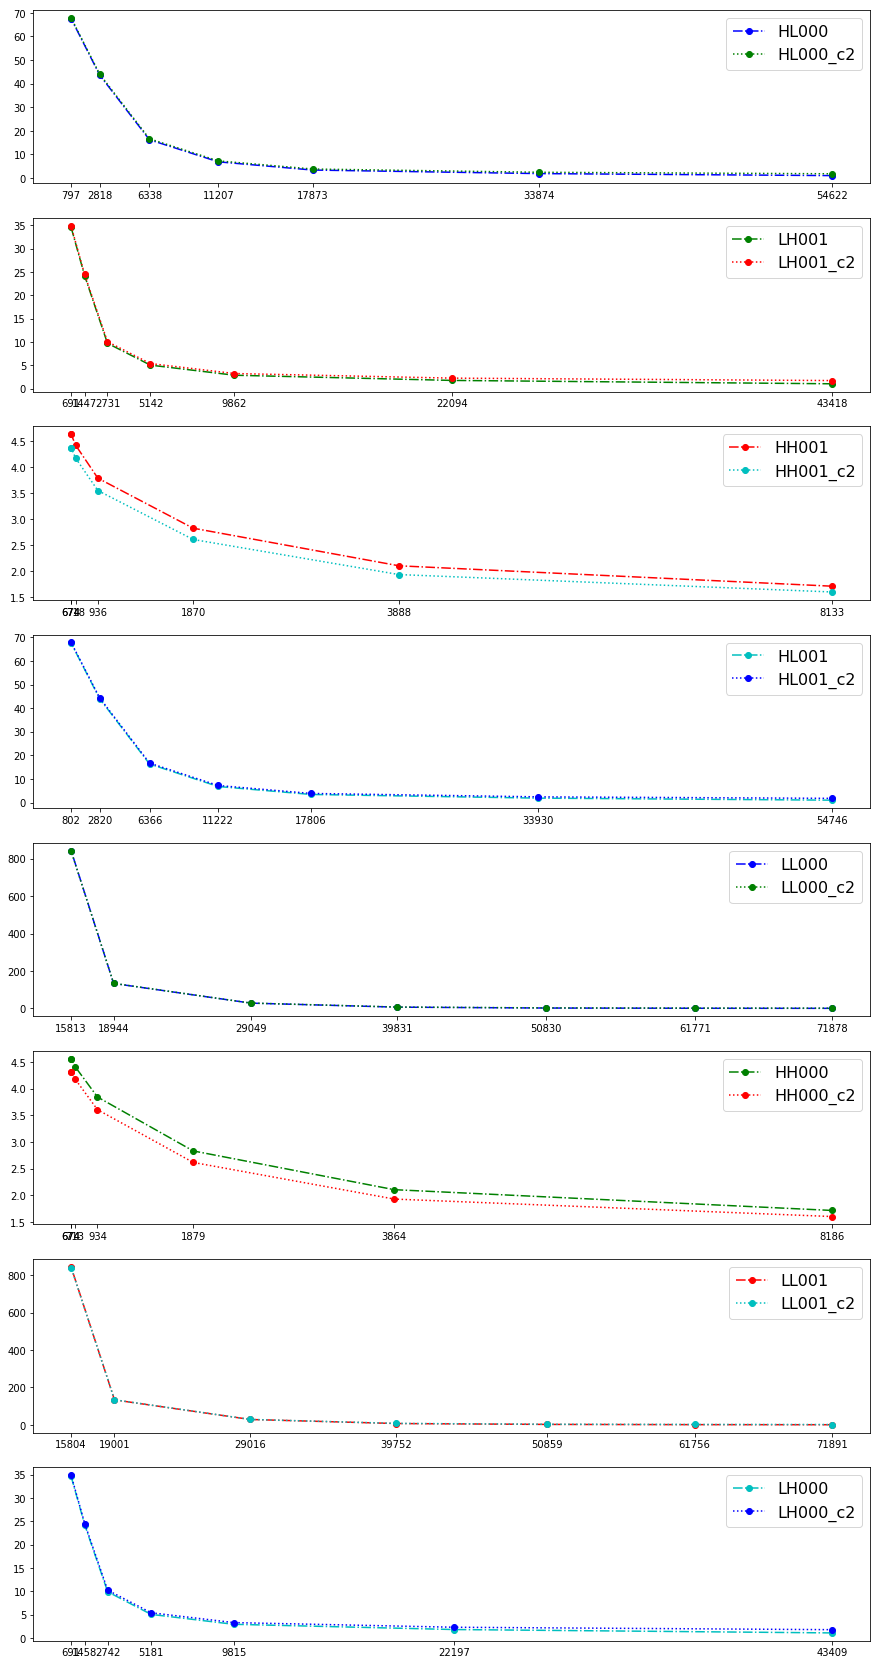

#######################################################################################


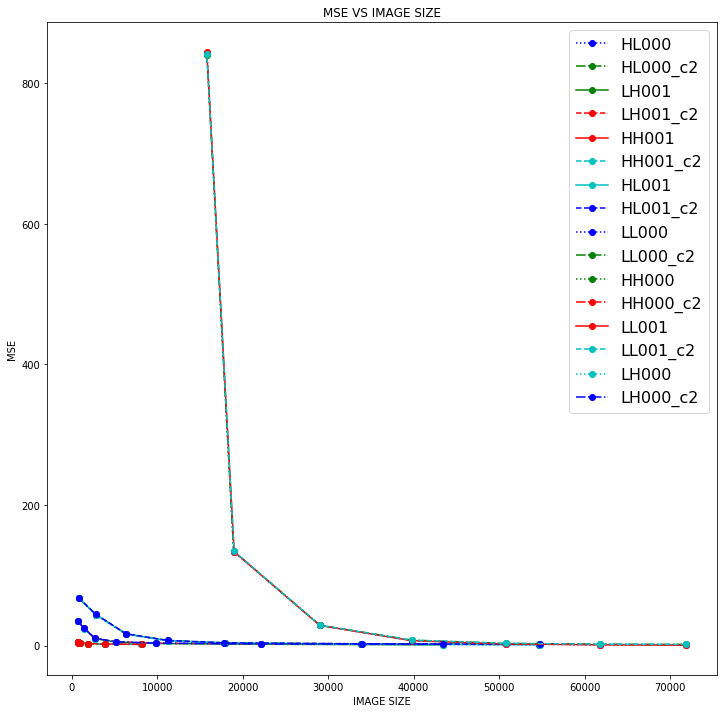

#######################################################################################
[(4.1101115319865316e-05, -20748.0, 0), (9.390195941036513e-05, -16001.0, 0), (0.0005221462013625605, -6666.0, 0), (0.001922037058430889, -4869.0, 0), (0.007787525467745639, -3520.0, 0), (0.011828223359585463, -2021.0, 0)]
[(3.377692895116045e-05, -21324.0, 1), (9.071061848868014e-05, -12232.0, 1), (0.0004585149863304656, -4720.0, 1), (0.0019377169402444187, -2411.0, 1), (0.011279444378068064, -1284.0, 1), (0.01362357140351932, -756.0, 1)]
[(9.237555546632396e-05, -4245.0, 2), (0.00035837402612597737, -2018.0, 2), (0.0010301506094131897, -934.0, 2), (0.00290923498169771, -218.0, 2), (0.004769821797520663, -44.0, 2), (nan, 0.0, 2)]
[(4.122179653471688e-05, -20816.0, 3), (9.672231356764119e-05, -16124.0, 3), (0.0005122946889919855, -6584.0, 3), (0.001960352566802706, -4856.0, 3), (0.00781609965097962, -3546.0, 3), (0.011657746005646154, -2018.0, 3)]
[(4.752162436425199e-05, -10107.0, 4), (0.0001095284

/home/usuario/Documents/sistemas_multimedia/MCDWT/env/lib/python3.5/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in double_scalars


In [26]:
# example on how to calculate rate for a curve 
# https://github.com/vicente-gonzalez-ruiz/bit_allocation/blob/master/bit_allocation.ipynb
from matplotlib import pyplot as plt
%matplotlib inline
colors=['b','g','r','c','b','g','r','c']
def calculate_rate(curve, curve2=None, R=6.4):
    C = len(curve)
    keys = list(curve.keys())
    plt.figure(figsize=(15,30))
    n_plot= 811
    for c in curve:
        plt.subplot(n_plot)
        size, mse = zip(*curve[c])
        plt.plot(size, mse, '-bo', color=colors[keys.index(c)], label=c, linestyle='-.')      
        if curve2 is not None:
            size2, mse2 = zip(*curve2[c])
            plt.plot(size2, mse2, '-bo', color=colors[(keys.index(c)+1)%len(colors)], label=c+'_c2', linestyle=':')
        plt.xticks(size)
        plt.legend(loc='best', prop={'size': 16})
        n_plot+=1        
    plt.show()
    print('#######################################################################################')
    fig=plt.figure(figsize=(12,12))
    for c in curve:
        curr_curve = curve[c]
        ls = '-'
        if '000' in c:
            ls = ':'
        plt.plot(*zip(*curr_curve), '-bo', color=colors[keys.index(c)], label=c, linestyle=ls)
        if curve2 is not None:
            curr_curve = curve2[c]
            ls = '--'
            if '000' in c:
                ls = '-.'
            i=(keys.index(c)+1)%len(colors)
            plt.plot(*zip(*curr_curve), '-bo', color=colors[i], label=c+'_c2', linestyle=ls)
    plt.title("MSE VS IMAGE SIZE")
    plt.xlabel("IMAGE SIZE")
    plt.ylabel("MSE")
    plt.legend(loc='best', prop={'size': 16})
    plt.show()
    print('#######################################################################################')
    slopes = [None]*C
    for c in range(C):
        # Slopes of each pair of points
        slopes[c] = []
        for i in range(len(curve[keys[c]])-1):
            distortion_decrease = curve[keys[c]][i][1] - curve[keys[c]][i+1][1]
            rate_increase = curve[keys[c]][i+1][0] - curve[keys[c]][i][0]
            slope = distortion_decrease/rate_increase
            slopes[c].append((slope, rate_increase, c))
        print(slopes[c])
    print('#######################################################################################')
    total_slopes = []
    for c in range(C):
        total_slopes += slopes[c]
    print(total_slopes)
    print('#######################################################################################')
    sorted_slopes = sorted(total_slopes, key=lambda tup: tup[0])[::-1]
    print(sorted_slopes)
    print('#######################################################################################')
    
    spent_br = 0 # Spent bit rate
    i = 0
    optimal_progression = []
    while (i < len(sorted_slopes)): #True:
        spent_br += sorted_slopes[i][1]
        if spent_br < R:
            optimal_progression.append(sorted_slopes[i])
        else:
            break
        i += 1
    #print("Optimal progression of RD points =", optimal_progression)
    br = sum([i[1] for i in optimal_progression])
    print("Achieved rate =", br)
    for c in range(len(curve)): # 4 = two curves
        br = sum([i[1] for i in optimal_progression if i[2] == c])
        print("Rate for curve {} = {}".format(keys[c],br))
calculate_rate(res, res1, R=R)

# CONFIGURE PARAMETERS

In [9]:
DEBUG=True
dir1 = '/tmp/test/'
min_qstep = 1
max_qstep = 7
LOOP_STEP = 1
#if power_of_two is set, loop will iterate 2^q_step
POWER_OF_TWO = True
if POWER_OF_TWO == True and max_qstep > 9: max_qstep = 9
normalize=True # no need to normalize if zeros =True
zeros=True #set other subbands to zero or keep original values
if zeros: normalize=False

# Calculate mse values and directory size for video 1

In [8]:
videofile_url = 'https://media.xiph.org/video/derf/y4m/akiyo_cif.y4m'
#videofile_url = 'https://media.xiph.org/video/derf/y4m/city_4cif.y4m'
zeros=True
mse_values = bit_allocation_in_MCDWT(dir1, videofile_url, min_qstep=min_qstep, max_qstep=max_qstep,powered_iterations=True, normalize=normalize,zeros=zeros)
zeros=False
mse_values1 = bit_allocation_in_MCDWT(dir1, videofile_url, min_qstep=min_qstep, max_qstep=max_qstep,powered_iterations=True, normalize=normalize,zeros=zeros)

# Extract and format results from the resulting json

## MIDTHREAD
### Video 1

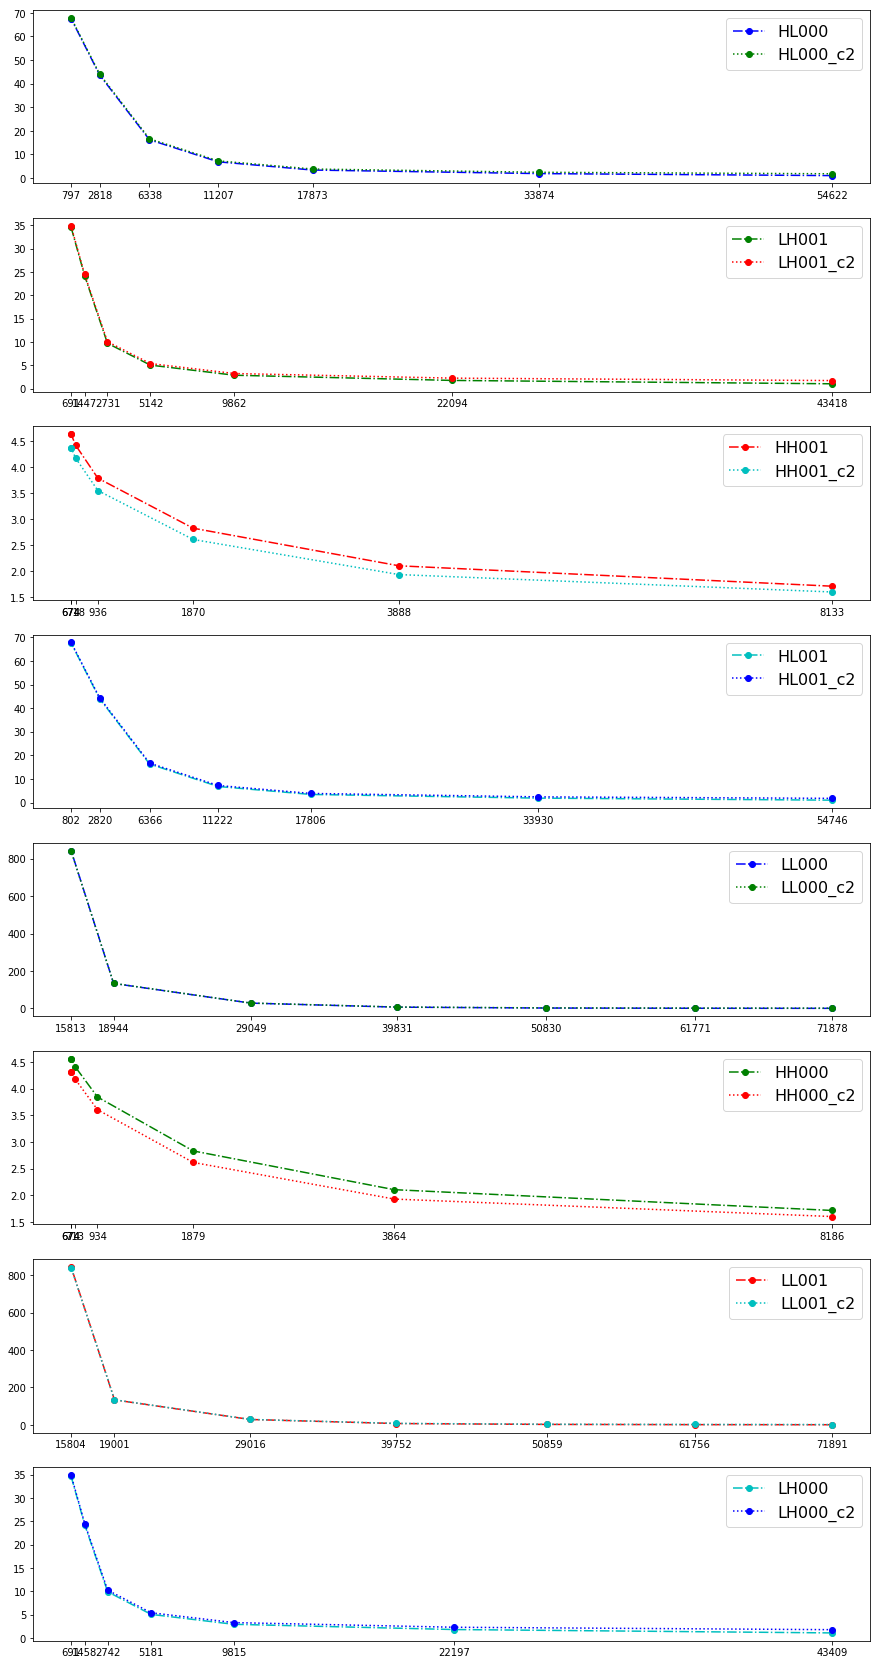

#######################################################################################


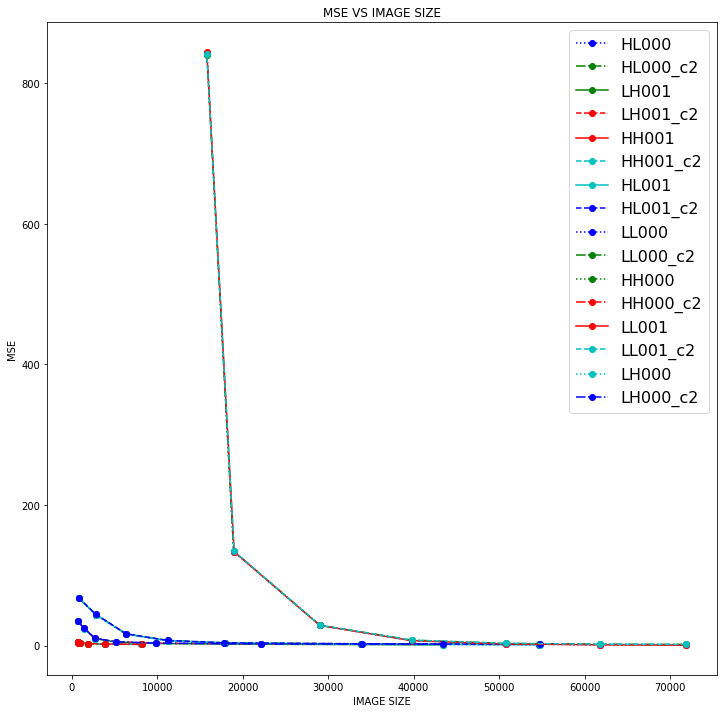

#######################################################################################
[(4.1101115319865316e-05, -20748.0, 0), (9.390195941036513e-05, -16001.0, 0), (0.0005221462013625605, -6666.0, 0), (0.001922037058430889, -4869.0, 0), (0.007787525467745639, -3520.0, 0), (0.011828223359585463, -2021.0, 0)]
[(3.377692895116045e-05, -21324.0, 1), (9.071061848868014e-05, -12232.0, 1), (0.0004585149863304656, -4720.0, 1), (0.0019377169402444187, -2411.0, 1), (0.011279444378068064, -1284.0, 1), (0.01362357140351932, -756.0, 1)]
[(9.237555546632396e-05, -4245.0, 2), (0.00035837402612597737, -2018.0, 2), (0.0010301506094131897, -934.0, 2), (0.00290923498169771, -218.0, 2), (0.004769821797520663, -44.0, 2), (nan, 0.0, 2)]
[(4.122179653471688e-05, -20816.0, 3), (9.672231356764119e-05, -16124.0, 3), (0.0005122946889919855, -6584.0, 3), (0.001960352566802706, -4856.0, 3), (0.00781609965097962, -3546.0, 3), (0.011657746005646154, -2018.0, 3)]
[(4.752162436425199e-05, -10107.0, 4), (0.0001095284

/home/usuario/Documents/sistemas_multimedia/MCDWT/env/lib/python3.5/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in double_scalars


In [27]:
R = 6.4 # Bit budget
res = separate_msevalues_results(mse_values)
res1 = separate_msevalues_results(mse_values1)
calculate_rate(res, res1, R=R)

### Video 2

In [24]:
#videofile_url = 'https://media.xiph.org/video/derf/y4m/akiyo_cif.y4m'
videofile_url = 'https://media.xiph.org/video/derf/y4m/city_4cif.y4m'
zeros=True
mse_values2 = bit_allocation_in_MCDWT(dir1, videofile_url, min_qstep=min_qstep, max_qstep=max_qstep,powered_iterations=True, normalize=normalize,zeros=zeros)
zeros=False
mse_values3 = bit_allocation_in_MCDWT(dir1, videofile_url, min_qstep=min_qstep, max_qstep=max_qstep,powered_iterations=True, normalize=normalize,zeros=zeros)

Limpiando directorio de trabajo: /tmp/test/
Descargando archivo: 'https://media.xiph.org/video/derf/y4m/city_4cif.y4m' a '/tmp/test/test_video'


Extrayendo 2 imagenes a /tmp/test/
Ejecutando MDWT.py para 2 imagenes inverse: False
Ejecutando MCDWT.py para imagenes 2, predictor 2, iteraciones 1 inverse: False
Calculando tamaño de directorios
sizeof: /tmp/test/2/original/: 1784210
sizeof: /tmp/test/2/res/: 2285686
--------------------------------------------------------------------------------------------
cuantificando imagenes arrlength: 8
--------------------------------------------------------------------------------------------
cuantificandor: midthread 
--------------------------------------------------------------------------------------------
descopmrimiendo imagenes cuantificadas
--------------------------------------------------------------------------------------------
cuantificandor: midthread, qstep: 2, sb HH 
------------------------------------------------------------------

Ejecutando MDWT.py para 2 imagenes inverse: True
Ejecutando MCDWT.py para imagenes 2, predictor 2, iteraciones 1 inverse: True
Ejecutando MDWT.py para 2 imagenes inverse: True
eliminando subbandas de /tmp/test/2/midthread/HL/000/04/qres/ (rm -rf ?????.png)
--------------------------------------------------------------------------------------------
calculando mse para q_func: midthread, qstep: 4
directorio: /tmp/test/2/midthread/HL/000/04/qres/
['000.png', '001.png']
mse A: /tmp/test/2/midthread/HL/000/04/res/000.png, B: /tmp/test/2/midthread/HL/000/04/qres/000.png - 1.9662666706123737
cuantificandor: midthread, qstep: 4, sb LH 
--------------------------------------------------------------------------------------------
calculando peso del directorio de las subbandas para q_func: midthread, qstep: 4
sizeof: /tmp/test/2/midthread/LH/000/04/qres/LL001.png: 1122
sizeof: /tmp/test/2/midthread/LH/000/04/qres/LH001.png: 1122
sizeof: /tmp/test/2/midthread/LH/000/04/qres/HL001.png: 1122
sizeof:

Ejecutando MDWT.py para 2 imagenes inverse: True
Ejecutando MCDWT.py para imagenes 2, predictor 2, iteraciones 1 inverse: True
Ejecutando MDWT.py para 2 imagenes inverse: True
eliminando subbandas de /tmp/test/2/midthread/LL/000/08/qres/ (rm -rf ?????.png)
--------------------------------------------------------------------------------------------
calculando mse para q_func: midthread, qstep: 8
directorio: /tmp/test/2/midthread/LL/000/08/qres/
['000.png', '001.png']
mse A: /tmp/test/2/midthread/LL/000/08/res/000.png, B: /tmp/test/2/midthread/LL/000/08/qres/000.png - 2.138309363162879
cuantificandor: midthread, qstep: 16, sb HH 
--------------------------------------------------------------------------------------------
calculando peso del directorio de las subbandas para q_func: midthread, qstep: 16
sizeof: /tmp/test/2/midthread/HH/000/16/qres/LL001.png: 1122
sizeof: /tmp/test/2/midthread/HH/000/16/qres/LH001.png: 1122
sizeof: /tmp/test/2/midthread/HH/000/16/qres/HL001.png: 1122
sizeof

Ejecutando MDWT.py para 2 imagenes inverse: True
Ejecutando MCDWT.py para imagenes 2, predictor 2, iteraciones 1 inverse: True
Ejecutando MDWT.py para 2 imagenes inverse: True
eliminando subbandas de /tmp/test/2/midthread/HL/000/32/qres/ (rm -rf ?????.png)
--------------------------------------------------------------------------------------------
calculando mse para q_func: midthread, qstep: 32
directorio: /tmp/test/2/midthread/HL/000/32/qres/
['000.png', '001.png']
mse A: /tmp/test/2/midthread/HL/000/32/res/000.png, B: /tmp/test/2/midthread/HL/000/32/qres/000.png - 34.09987077809343
cuantificandor: midthread, qstep: 32, sb LH 
--------------------------------------------------------------------------------------------
calculando peso del directorio de las subbandas para q_func: midthread, qstep: 32
sizeof: /tmp/test/2/midthread/LH/000/32/qres/LL001.png: 1122
sizeof: /tmp/test/2/midthread/LH/000/32/qres/LH001.png: 1122
sizeof: /tmp/test/2/midthread/LH/000/32/qres/HL001.png: 1122
sizeo

Ejecutando MDWT.py para 2 imagenes inverse: True
Ejecutando MCDWT.py para imagenes 2, predictor 2, iteraciones 1 inverse: True
Ejecutando MDWT.py para 2 imagenes inverse: True
eliminando subbandas de /tmp/test/2/midthread/LL/000/64/qres/ (rm -rf ?????.png)
--------------------------------------------------------------------------------------------
calculando mse para q_func: midthread, qstep: 64
directorio: /tmp/test/2/midthread/LL/000/64/qres/
['000.png', '001.png']
mse A: /tmp/test/2/midthread/LL/000/64/res/000.png, B: /tmp/test/2/midthread/LL/000/64/qres/000.png - 112.20143821022727
cuantificandor: midthread, qstep: 128, sb HH 
--------------------------------------------------------------------------------------------
calculando peso del directorio de las subbandas para q_func: midthread, qstep: 128
sizeof: /tmp/test/2/midthread/HH/000/128/qres/LL001.png: 1122
sizeof: /tmp/test/2/midthread/HH/000/128/qres/LH001.png: 1122
sizeof: /tmp/test/2/midthread/HH/000/128/qres/HL001.png: 1122

Ejecutando MDWT.py para 2 imagenes inverse: True
Ejecutando MCDWT.py para imagenes 2, predictor 2, iteraciones 1 inverse: True
Ejecutando MDWT.py para 2 imagenes inverse: True
eliminando subbandas de /tmp/test/2/midthread/HL/001/02/qres/ (rm -rf ?????.png)
--------------------------------------------------------------------------------------------
calculando mse para q_func: midthread, qstep: 2
directorio: /tmp/test/2/midthread/HL/001/02/qres/
['000.png', '001.png']
mse A: /tmp/test/2/midthread/HL/001/02/res/001.png, B: /tmp/test/2/midthread/HL/001/02/qres/001.png - 0.9851789378156566
cuantificandor: midthread, qstep: 2, sb LH 
--------------------------------------------------------------------------------------------
calculando peso del directorio de las subbandas para q_func: midthread, qstep: 2
sizeof: /tmp/test/2/midthread/LH/001/02/qres/LL001.png: 1122
sizeof: /tmp/test/2/midthread/LH/001/02/qres/LH001.png: 251224
sizeof: /tmp/test/2/midthread/LH/001/02/qres/HL001.png: 1122
sizeo

Ejecutando MDWT.py para 2 imagenes inverse: True
Ejecutando MCDWT.py para imagenes 2, predictor 2, iteraciones 1 inverse: True
Ejecutando MDWT.py para 2 imagenes inverse: True
eliminando subbandas de /tmp/test/2/midthread/LL/001/04/qres/ (rm -rf ?????.png)
--------------------------------------------------------------------------------------------
calculando mse para q_func: midthread, qstep: 4
directorio: /tmp/test/2/midthread/LL/001/04/qres/
['000.png', '001.png']
mse A: /tmp/test/2/midthread/LL/001/04/res/001.png, B: /tmp/test/2/midthread/LL/001/04/qres/001.png - 0.9592309816919192
cuantificandor: midthread, qstep: 8, sb HH 
--------------------------------------------------------------------------------------------
calculando peso del directorio de las subbandas para q_func: midthread, qstep: 8
sizeof: /tmp/test/2/midthread/HH/001/08/qres/LL001.png: 1122
sizeof: /tmp/test/2/midthread/HH/001/08/qres/LH001.png: 1122
sizeof: /tmp/test/2/midthread/HH/001/08/qres/HL001.png: 1122
sizeof:

Ejecutando MDWT.py para 2 imagenes inverse: True
Ejecutando MCDWT.py para imagenes 2, predictor 2, iteraciones 1 inverse: True
Ejecutando MDWT.py para 2 imagenes inverse: True
eliminando subbandas de /tmp/test/2/midthread/HL/001/16/qres/ (rm -rf ?????.png)
--------------------------------------------------------------------------------------------
calculando mse para q_func: midthread, qstep: 16
directorio: /tmp/test/2/midthread/HL/001/16/qres/
['000.png', '001.png']
mse A: /tmp/test/2/midthread/HL/001/16/res/001.png, B: /tmp/test/2/midthread/HL/001/16/qres/001.png - 16.56050988399621
cuantificandor: midthread, qstep: 16, sb LH 
--------------------------------------------------------------------------------------------
calculando peso del directorio de las subbandas para q_func: midthread, qstep: 16
sizeof: /tmp/test/2/midthread/LH/001/16/qres/LL001.png: 1122
sizeof: /tmp/test/2/midthread/LH/001/16/qres/LH001.png: 76273
sizeof: /tmp/test/2/midthread/LH/001/16/qres/HL001.png: 1122
size

Ejecutando MDWT.py para 2 imagenes inverse: True
Ejecutando MCDWT.py para imagenes 2, predictor 2, iteraciones 1 inverse: True
Ejecutando MDWT.py para 2 imagenes inverse: True
eliminando subbandas de /tmp/test/2/midthread/LL/001/32/qres/ (rm -rf ?????.png)
--------------------------------------------------------------------------------------------
calculando mse para q_func: midthread, qstep: 32
directorio: /tmp/test/2/midthread/LL/001/32/qres/
['000.png', '001.png']
mse A: /tmp/test/2/midthread/LL/001/32/res/001.png, B: /tmp/test/2/midthread/LL/001/32/qres/001.png - 26.718098958333332
cuantificandor: midthread, qstep: 64, sb HH 
--------------------------------------------------------------------------------------------
calculando peso del directorio de las subbandas para q_func: midthread, qstep: 64
sizeof: /tmp/test/2/midthread/HH/001/64/qres/LL001.png: 1122
sizeof: /tmp/test/2/midthread/HH/001/64/qres/LH001.png: 1122
sizeof: /tmp/test/2/midthread/HH/001/64/qres/HL001.png: 1122
size

Ejecutando MDWT.py para 2 imagenes inverse: True
Ejecutando MCDWT.py para imagenes 2, predictor 2, iteraciones 1 inverse: True
Ejecutando MDWT.py para 2 imagenes inverse: True
eliminando subbandas de /tmp/test/2/midthread/HL/001/128/qres/ (rm -rf ?????.png)
--------------------------------------------------------------------------------------------
calculando mse para q_func: midthread, qstep: 128
directorio: /tmp/test/2/midthread/HL/001/128/qres/
['000.png', '001.png']
mse A: /tmp/test/2/midthread/HL/001/128/res/001.png, B: /tmp/test/2/midthread/HL/001/128/qres/001.png - 64.33912859059343
cuantificandor: midthread, qstep: 128, sb LH 
--------------------------------------------------------------------------------------------
calculando peso del directorio de las subbandas para q_func: midthread, qstep: 128
sizeof: /tmp/test/2/midthread/LH/001/128/qres/LL001.png: 1122
sizeof: /tmp/test/2/midthread/LH/001/128/qres/LH001.png: 1975
sizeof: /tmp/test/2/midthread/LH/001/128/qres/HL001.png: 

Ejecutando MDWT.py para 2 imagenes inverse: True
eliminando subbandas de /tmp/test/2/midthread/LL/000/02/qres/ (rm -rf ?????.png)
--------------------------------------------------------------------------------------------
calculando mse para q_func: midthread, qstep: 2
directorio: /tmp/test/2/midthread/LL/000/02/qres/
['000.png', '001.png']
mse A: /tmp/test/2/original/000.png, B: /tmp/test/2/midthread/LL/000/02/qres/000.png - 1.5570746527777777
cuantificandor: midthread, qstep: 4, sb HH 
--------------------------------------------------------------------------------------------
calculando peso del directorio de las subbandas para q_func: midthread, qstep: 4
sizeof: /tmp/test/2/midthread/HH/000/04/qres/LL001.png: 400124
sizeof: /tmp/test/2/midthread/HH/000/04/qres/LH001.png: 291428
sizeof: /tmp/test/2/midthread/HH/000/04/qres/HL001.png: 308330
sizeof: /tmp/test/2/midthread/HH/000/04/qres/HH000.png: 23115
sizeof: /tmp/test/2/midthread/HH/000/04/qres/LH000.png: 293911
sizeof: /tmp/test/

Ejecutando MDWT.py para 2 imagenes inverse: True
eliminando subbandas de /tmp/test/2/midthread/LH/000/08/qres/ (rm -rf ?????.png)
--------------------------------------------------------------------------------------------
calculando mse para q_func: midthread, qstep: 8
directorio: /tmp/test/2/midthread/LH/000/08/qres/
['000.png', '001.png']
mse A: /tmp/test/2/original/000.png, B: /tmp/test/2/midthread/LH/000/08/qres/000.png - 5.9789570509785355
cuantificandor: midthread, qstep: 8, sb LL 
--------------------------------------------------------------------------------------------
calculando peso del directorio de las subbandas para q_func: midthread, qstep: 8
sizeof: /tmp/test/2/midthread/LL/000/08/qres/LL001.png: 400124
sizeof: /tmp/test/2/midthread/LL/000/08/qres/LH001.png: 291428
sizeof: /tmp/test/2/midthread/LL/000/08/qres/HL001.png: 308330
sizeof: /tmp/test/2/midthread/LL/000/08/qres/HH000.png: 144822
sizeof: /tmp/test/2/midthread/LL/000/08/qres/LH000.png: 293911
sizeof: /tmp/test

Ejecutando MDWT.py para 2 imagenes inverse: True
eliminando subbandas de /tmp/test/2/midthread/HL/000/32/qres/ (rm -rf ?????.png)
--------------------------------------------------------------------------------------------
calculando mse para q_func: midthread, qstep: 32
directorio: /tmp/test/2/midthread/HL/000/32/qres/
['000.png', '001.png']
mse A: /tmp/test/2/original/000.png, B: /tmp/test/2/midthread/HL/000/32/qres/000.png - 34.50250799005682
cuantificandor: midthread, qstep: 32, sb LH 
--------------------------------------------------------------------------------------------
calculando peso del directorio de las subbandas para q_func: midthread, qstep: 32
sizeof: /tmp/test/2/midthread/LH/000/32/qres/LL001.png: 400124
sizeof: /tmp/test/2/midthread/LH/000/32/qres/LH001.png: 291428
sizeof: /tmp/test/2/midthread/LH/000/32/qres/HL001.png: 308330
sizeof: /tmp/test/2/midthread/LH/000/32/qres/HH000.png: 144822
sizeof: /tmp/test/2/midthread/LH/000/32/qres/LH000.png: 34700
sizeof: /tmp/tes

Ejecutando MDWT.py para 2 imagenes inverse: True
eliminando subbandas de /tmp/test/2/midthread/HH/000/128/qres/ (rm -rf ?????.png)
--------------------------------------------------------------------------------------------
calculando mse para q_func: midthread, qstep: 128
directorio: /tmp/test/2/midthread/HH/000/128/qres/
['000.png', '001.png']
mse A: /tmp/test/2/original/000.png, B: /tmp/test/2/midthread/HH/000/128/qres/000.png - 5.5879498106060606
cuantificandor: midthread, qstep: 128, sb HL 
--------------------------------------------------------------------------------------------
calculando peso del directorio de las subbandas para q_func: midthread, qstep: 128
sizeof: /tmp/test/2/midthread/HL/000/128/qres/LL001.png: 400124
sizeof: /tmp/test/2/midthread/HL/000/128/qres/LH001.png: 291428
sizeof: /tmp/test/2/midthread/HL/000/128/qres/HL001.png: 308330
sizeof: /tmp/test/2/midthread/HL/000/128/qres/HH000.png: 144822
sizeof: /tmp/test/2/midthread/HL/000/128/qres/LH000.png: 293911
siz

Ejecutando MDWT.py para 2 imagenes inverse: True
eliminando subbandas de /tmp/test/2/midthread/LL/001/02/qres/ (rm -rf ?????.png)
--------------------------------------------------------------------------------------------
calculando mse para q_func: midthread, qstep: 2
directorio: /tmp/test/2/midthread/LL/001/02/qres/
['000.png', '001.png']
mse A: /tmp/test/2/original/001.png, B: /tmp/test/2/midthread/LL/001/02/qres/001.png - 1.5594815340909092
cuantificandor: midthread, qstep: 4, sb HH 
--------------------------------------------------------------------------------------------
calculando peso del directorio de las subbandas para q_func: midthread, qstep: 4
sizeof: /tmp/test/2/midthread/HH/001/04/qres/LL001.png: 400124
sizeof: /tmp/test/2/midthread/HH/001/04/qres/LH001.png: 291428
sizeof: /tmp/test/2/midthread/HH/001/04/qres/HL001.png: 308330
sizeof: /tmp/test/2/midthread/HH/001/04/qres/HH000.png: 144822
sizeof: /tmp/test/2/midthread/HH/001/04/qres/LH000.png: 293911
sizeof: /tmp/test

Ejecutando MDWT.py para 2 imagenes inverse: True
eliminando subbandas de /tmp/test/2/midthread/LH/001/08/qres/ (rm -rf ?????.png)
--------------------------------------------------------------------------------------------
calculando mse para q_func: midthread, qstep: 8
directorio: /tmp/test/2/midthread/LH/001/08/qres/
['000.png', '001.png']
mse A: /tmp/test/2/original/001.png, B: /tmp/test/2/midthread/LH/001/08/qres/001.png - 5.87084714330808
cuantificandor: midthread, qstep: 8, sb LL 
--------------------------------------------------------------------------------------------
calculando peso del directorio de las subbandas para q_func: midthread, qstep: 8
sizeof: /tmp/test/2/midthread/LL/001/08/qres/LL001.png: 280873
sizeof: /tmp/test/2/midthread/LL/001/08/qres/LH001.png: 291428
sizeof: /tmp/test/2/midthread/LL/001/08/qres/HL001.png: 308330
sizeof: /tmp/test/2/midthread/LL/001/08/qres/HH000.png: 144822
sizeof: /tmp/test/2/midthread/LL/001/08/qres/LH000.png: 293911
sizeof: /tmp/test/2

Ejecutando MDWT.py para 2 imagenes inverse: True
eliminando subbandas de /tmp/test/2/midthread/HL/001/32/qres/ (rm -rf ?????.png)
--------------------------------------------------------------------------------------------
calculando mse para q_func: midthread, qstep: 32
directorio: /tmp/test/2/midthread/HL/001/32/qres/
['000.png', '001.png']
mse A: /tmp/test/2/original/001.png, B: /tmp/test/2/midthread/HL/001/32/qres/001.png - 40.012892597853536
cuantificandor: midthread, qstep: 32, sb LH 
--------------------------------------------------------------------------------------------
calculando peso del directorio de las subbandas para q_func: midthread, qstep: 32
sizeof: /tmp/test/2/midthread/LH/001/32/qres/LL001.png: 400124
sizeof: /tmp/test/2/midthread/LH/001/32/qres/LH001.png: 32464
sizeof: /tmp/test/2/midthread/LH/001/32/qres/HL001.png: 308330
sizeof: /tmp/test/2/midthread/LH/001/32/qres/HH000.png: 144822
sizeof: /tmp/test/2/midthread/LH/001/32/qres/LH000.png: 293911
sizeof: /tmp/te

Ejecutando MDWT.py para 2 imagenes inverse: True
eliminando subbandas de /tmp/test/2/midthread/HH/001/128/qres/ (rm -rf ?????.png)
--------------------------------------------------------------------------------------------
calculando mse para q_func: midthread, qstep: 128
directorio: /tmp/test/2/midthread/HH/001/128/qres/
['000.png', '001.png']
mse A: /tmp/test/2/original/001.png, B: /tmp/test/2/midthread/HH/001/128/qres/001.png - 6.151451033775253
cuantificandor: midthread, qstep: 128, sb HL 
--------------------------------------------------------------------------------------------
calculando peso del directorio de las subbandas para q_func: midthread, qstep: 128
sizeof: /tmp/test/2/midthread/HL/001/128/qres/LL001.png: 400124
sizeof: /tmp/test/2/midthread/HL/001/128/qres/LH001.png: 291428
sizeof: /tmp/test/2/midthread/HL/001/128/qres/HL001.png: 1664
sizeof: /tmp/test/2/midthread/HL/001/128/qres/HH000.png: 144822
sizeof: /tmp/test/2/midthread/HL/001/128/qres/LH000.png: 293911
sizeof

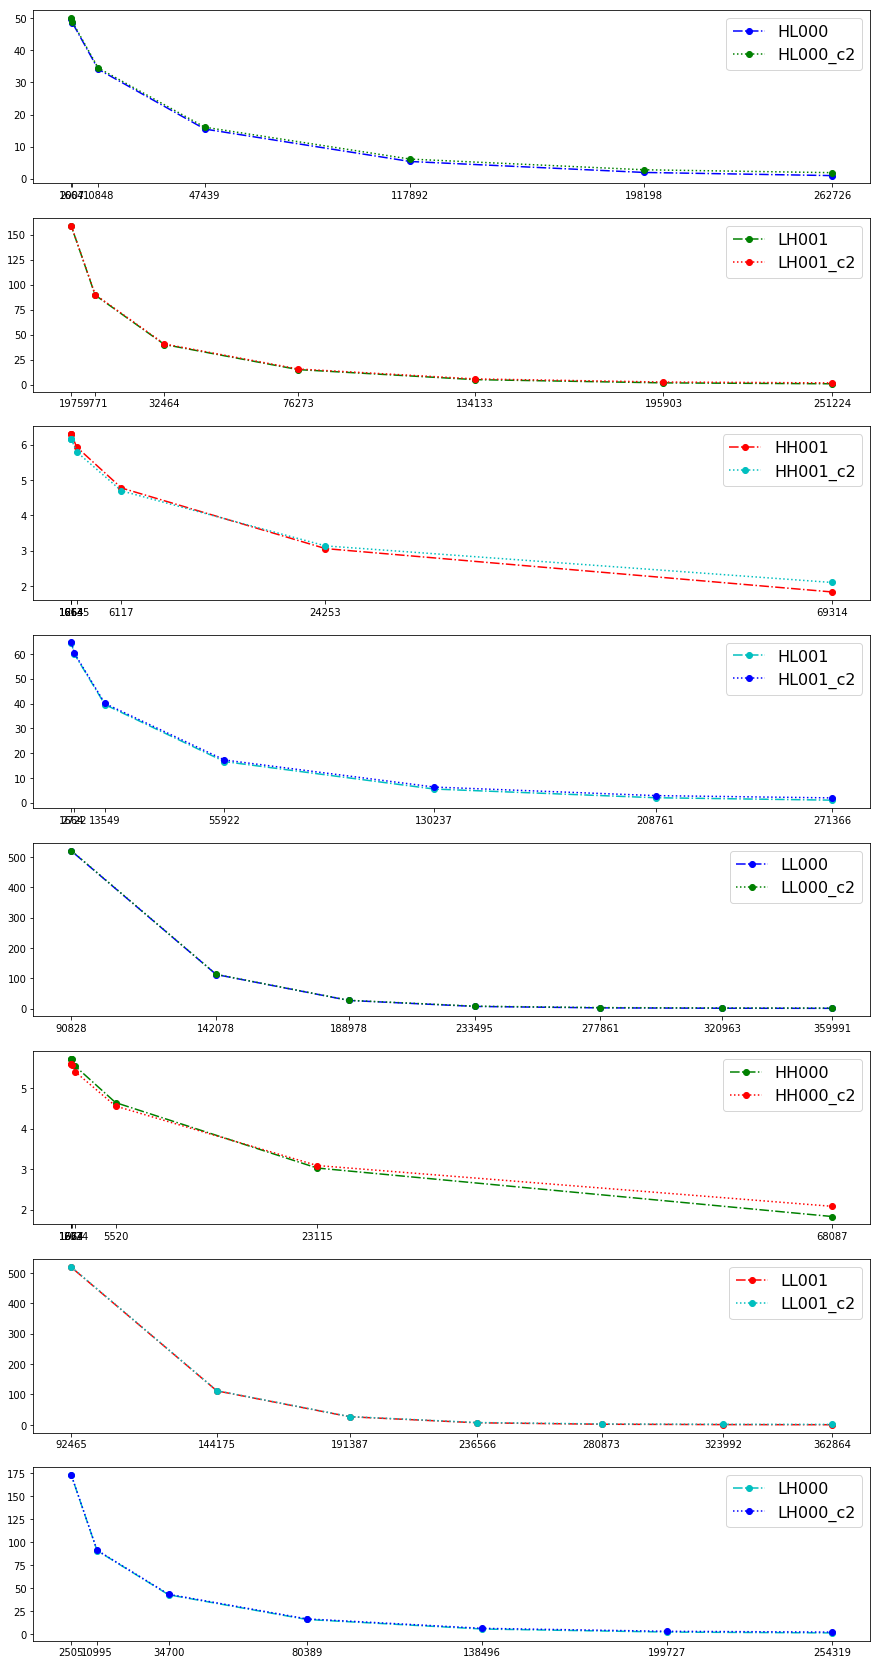

#######################################################################################


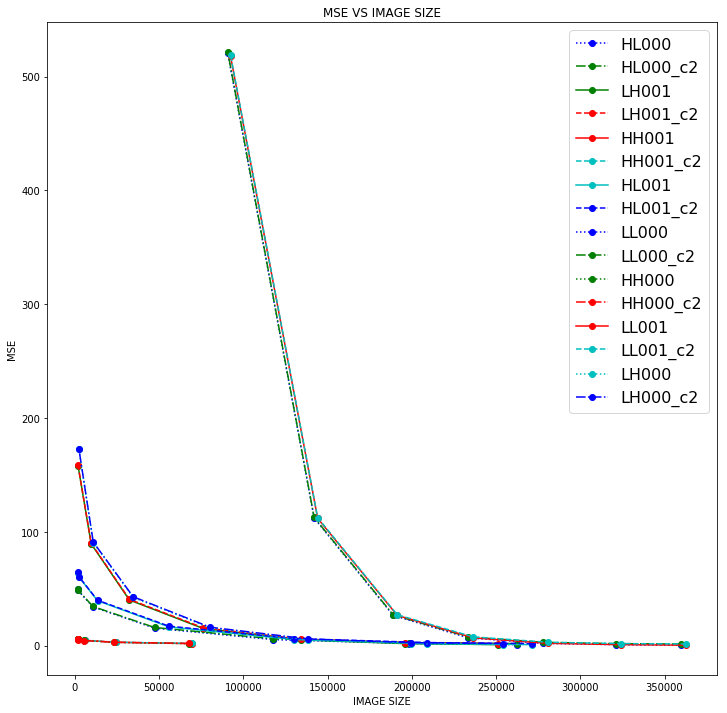

#######################################################################################
[(1.520337440478818e-05, -64528.0, 0), (4.247407661708799e-05, -80306.0, 0), (0.00014325079012485865, -70453.0, 0), (0.0005091479597169393, -36591.0, 0), (0.001634486895004079, -8841.0, 0), (0.0036127233293209117, -343.0, 0)]
[(1.6699544896165244e-05, -55321.0, 1), (5.2521196949051795e-05, -61770.0, 1), (0.00017266653843459658, -57860.0, 1), (0.0005715927013168216, -43809.0, 1), (0.0021731479838958258, -22693.0, 1), (0.008809684968795509, -7796.0, 1)]
[(2.727942528144789e-05, -45061.0, 2), (9.463858145617234e-05, -18136.0, 2), (0.00029151425357448155, -3982.0, 2), (0.0007679520875554919, -471.0, 2), (nan, 0.0, 2), (nan, 0.0, 2)]
[(1.566138615661043e-05, -62605.0, 3), (4.46506847702163e-05, -78524.0, 3), (0.00014921213072662982, -74315.0, 3), (0.0005428792603989295, -42373.0, 3), (0.0018862993013310575, -10827.0, 3), (0.0041136420323270514, -1058.0, 3)]
[(1.0742252709107837e-05, -39028.0, 4), (2.7442

/home/usuario/Documents/sistemas_multimedia/MCDWT/env/lib/python3.5/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in double_scalars


In [28]:
R = 6.4 # Bit budget
res2 = separate_msevalues_results(mse_values2)
res3 = separate_msevalues_results(mse_values3)
calculate_rate(res2, res3, R=R)